## COVID-19 country comparison

This generates a series of visualizations from the raw data tables, showing some aspects of the ongoing Covid-19 epidemic that I couldn't find in other reports.

Shared on Reddit [here](https://www.reddit.com/r/dataisbeautiful/comments/ff9jn4/oc_number_of_cases_per_country_counting_from_the/).

In [39]:
# Builtins
import datetime
import math
import requests
from io import StringIO

# Third party modules
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from IPython.display import display
import numpy as np
from scipy.optimize import curve_fit

register_matplotlib_converters()
light_grey = (.98, .98, .98, 1) 
matplotlib.rcParams['figure.figsize'] = (14, 8)        # Default size of all figures
matplotlib.rcParams['axes.facecolor'] = light_grey     # Default background color of all graph areas
matplotlib.rcParams['figure.facecolor'] = light_grey   # Default background color of all figure borders
cm = plt.cm.get_cmap('nipy_spectral')                  # This colormap is used for the colors of the plot lines

# Where to get the data
base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
data_urls = {
    "confirmed": "time_series_19-covid-Confirmed.csv",
    "deaths":    "time_series_19-covid-Deaths.csv",
    "recovered": "time_series_19-covid-Recovered.csv"    
}

# Convenience function for labelling the y-axis
def set_y_axis_format(log=True):
    if log:
        plt.yscale("log")
    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:,.0f}"))

### Retrieve the latest version of the data and transform it into a set of Pandas dataframes

Show the first few rows of the confirmed cases dataframe for illustration.

In [40]:
# Set up a dictionary to store all the data in
dataframes = {}
for metric in data_urls.keys():
    url = base_url + data_urls[metric]                             # Combine URL parts
    r = requests.get(url)                                          # Retrieve from URL
    dataframes[metric] = pd.read_csv(StringIO(r.text), sep=",")    # Convert into Pandas dataframe
    
# Display the first 10 lines
display(dataframes["confirmed"].iloc[:15, :])

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20
0,Anhui,Mainland China,31.82570,117.2264,1,9,15,39,60,70,...,990,990,990,990,990,990,990,990,990,990
1,Beijing,Mainland China,40.18240,116.4142,14,22,36,41,68,80,...,410,411,413,414,414,418,418,422,426,428
2,Chongqing,Mainland China,30.05720,107.8740,6,9,27,57,75,110,...,576,576,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.07890,117.9874,1,5,10,18,35,59,...,296,296,296,296,296,296,296,296,296,296
4,Gansu,Mainland China,36.06110,103.8343,0,2,2,4,7,14,...,91,91,91,91,91,91,102,119,120,124
5,Guangdong,Mainland China,23.34170,113.4244,26,32,53,78,111,151,...,1348,1349,1349,1350,1350,1350,1351,1352,1352,1352
6,Guangxi,Mainland China,23.82980,108.7881,2,5,23,23,36,46,...,252,252,252,252,252,252,252,252,252,252
7,Guizhou,Mainland China,26.81540,106.8748,1,3,3,4,5,7,...,146,146,146,146,146,146,146,146,146,146
8,Hainan,Mainland China,19.19590,109.7453,4,5,8,19,22,33,...,168,168,168,168,168,168,168,168,168,168
9,Hebei,Mainland China,38.04280,114.5149,1,1,2,8,13,18,...,318,318,318,318,318,318,318,318,318,318


### Process and add up all provinces/states into one row per country 

In [41]:
for metric in data_urls.keys():
    by_country = dataframes[metric].groupby("Country/Region").sum()           # Group by country
    dates = by_country.columns[2:]                                            # Drop Lat/Long columns
    by_country.loc["All except China", dates] =\
        by_country.sum().loc[dates]-by_country.loc["Mainland China", dates]   # Add "Outside China" row
    by_country = by_country.loc[:, dates].astype(int)                         # Convert to columns to matplotlib dates
    dates = pd.to_datetime(dates)
    by_country.columns = dates

    if metric == "confirmed":
        # Add in some data points for China from before the start of the Johns Hopkins data.
        # Source: https://en.wikipedia.org/wiki/Timeline_of_the_2019%E2%80%9320_coronavirus_outbreak_in_December_2019_%E2%80%93_January_2020
        early_china_data = {
            "1/17/20": 45,
            "1/18/20": 62,
            "1/20/20": 218
        }
        for d, n in early_china_data.items():
            by_country.loc["Mainland China", pd.to_datetime(d)] = n               # Insert early China data point
        by_country = by_country.reindex(list(sorted(by_country.columns)), axis=1) # Retain chronological column order
        by_country = by_country.fillna(0)
        
        # Correct an odd blip in the Japanese data. 
        # From 2/5 to 2/7, the Johns Hopkins data for Japan goes 22, 45, 25. 
        # I assume that the 45 is incorrect.
        by_country.loc["Japan", pd.to_datetime("2/06/20")] = 23.5      #  Halfway between values for 2/5 and 2/7
        
    dataframes[metric+"_by_country"] = by_country
    
confirmed_by_country = dataframes["confirmed_by_country"]              # Shorthand

with pd.option_context("display.max_rows", 20, "display.max_columns", 10):
    display(dataframes["confirmed_by_country"])

,2020-01-17,2020-01-18,2020-01-20,2020-01-22,2020-01-23,...,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08
Country/Region,,,,,,,,,,,
Afghanistan,0.0,0.0,0.0,0,0,...,1,1,1,1,4
Algeria,0.0,0.0,0.0,0,0,...,12,12,17,17,19
Andorra,0.0,0.0,0.0,0,0,...,1,1,1,1,1
Argentina,0.0,0.0,0.0,0,0,...,1,1,2,8,12
Armenia,0.0,0.0,0.0,0,0,...,1,1,1,1,1
Australia,0.0,0.0,0.0,0,0,...,52,55,60,63,76
Austria,0.0,0.0,0.0,0,0,...,29,41,55,79,104
Azerbaijan,0.0,0.0,0.0,0,0,...,3,6,6,9,9
Bahrain,0.0,0.0,0.0,0,0,...,52,55,60,85,85


### List all countries in the `by_country` table

In [42]:
for i, k in enumerate(confirmed_by_country.index):
    if len(k) > 16:
        k = k[:15] + "."
    print(f"{k:17}", end=" " if (i+1) % 5 else "\n")      # Every 5 items, end with a newline

Afghanistan       Algeria           Andorra           Argentina         Armenia          
Australia         Austria           Azerbaijan        Bahrain           Bangladesh       
Belarus           Belgium           Bhutan            Bosnia and Herz.  Brazil           
Bulgaria          Cambodia          Cameroon          Canada            Chile            
Colombia          Costa Rica        Croatia           Czech Republic    Denmark          
Dominican Repub.  Ecuador           Egypt             Estonia           Faroe Islands    
Finland           France            French Guiana     Georgia           Germany          
Gibraltar         Greece            Hong Kong         Hungary           Iceland          
India             Indonesia         Iran              Iraq              Ireland          
Israel            Italy             Japan             Jordan            Kuwait           
Latvia            Lebanon           Liechtenstein     Lithuania         Luxembourg       
Macau     

In [43]:
def plot(x_metric, y_metric, countries_to_plot, markers="o.^v<>sXD*", colormap=cm, 
         use_log_scale=True, min_cases=40, n_days_average=5):
    short_metric_to_long = {
        "confirmed": "Confirmed cases",
        "deaths":    "Deaths",
        "active":    "Active cases",
        "growth_factor": f"{n_days_average}-day-average growth factor"
    }
    fills = ["none", "full"]
    length = None
    m = len(markers)
    cm = plt.cm.get_cmap(colormap)
    cNorm = matplotlib.colors.Normalize(vmin=0, vmax=len(countries_to_plot))
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)
    if y_metric in dataframes:
        by_country   = dataframes[y_metric+"_by_country"]
    elif y_metric == "growth_factor":
        by_country   = dataframes["confirmed_by_country"]
    elif y_metric == "active":
        by_country = dataframes["confirmed_by_country"] - \
                     dataframes["deaths_by_country"] - \
                     dataframes["recovered_by_country"] 
    else:
        print(f"{y_metric}' is an invalid y_metric!")
        
    for i, country in enumerate(countries_to_plot):
        country_data = by_country.loc[country] # , dates]
        fill = fills[i % (2*len(markers)) < len(markers)]
        
        if y_metric == "growth_factor":
            if x_metric == "day_number":
                country_data = country_data[country_data >= min_cases]
            country_data = country_data.diff() / country_data + 1
            country_data = np.convolve(country_data, np.ones(n_days_average)/n_days_average, mode="valid")
            
        is_valid = sum(np.nan_to_num(country_data)) > 0
        
        if x_metric == "calendar_date" and is_valid:
            plt.plot(country_data, markers[i%m]+"-", label=country, 
                 markersize=6, color=scalarMap.to_rgba(i), alpha=1, fillstyle=fill)
            
        elif x_metric == "day_number":                   
            if y_metric != "growth_factor":
                country_data = country_data[country_data >= min_cases]
            if country == "Outside China":
                length = len(country_data)
            day_nr = list(range(len(country_data)))
            if is_valid:
                plt.plot(day_nr, country_data, markers[i%m]+"-", label=country, 
                         markersize=6, color=scalarMap.to_rgba(i), alpha=1, fillstyle=fill)
      
    long_y_metric = short_metric_to_long[y_metric]
    plt.ylabel(long_y_metric, fontsize=14)
    if x_metric == "calendar_date":
        plt.xlabel("Date", fontsize=14)
        plt.title(f"COVID-19 {long_y_metric} over time in selected countries", fontsize=16)
        plt.ylim(0.9, by_country.loc[countries_to_plot].max().max()*(2-0.9*(not use_log_scale)))
    elif x_metric == "day_number":
        plt.xlim(0, length)
        if y_metric in dataframes:
            ten_floor = 10**math.floor(math.log(min_cases)/math.log(10))
            floor = ten_floor * (1 - (not use_log_scale)) 
            plt.ylim(floor, by_country.loc[countries_to_plot].max().max()*(2-0.9*(not use_log_scale)))
        plt.xlabel("Day Number", fontsize=14)
        plt.title(f"COVID-19 {long_y_metric}, from the first day with ≥{min_cases} local cases, in selected countries", 
                  fontsize=16)
        
    plt.legend()
    if y_metric == "growth_factor":
        plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:,.2f}"))
        plt.ylabel("Growth Factor", fontsize=14)
    else:
        set_y_axis_format(use_log_scale)
    plt.grid()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().tick_params(which="minor", width=0)
    plt.gca().tick_params(which="major", color=light_grey)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.show()

### Plot cases over calendar date in selected countries

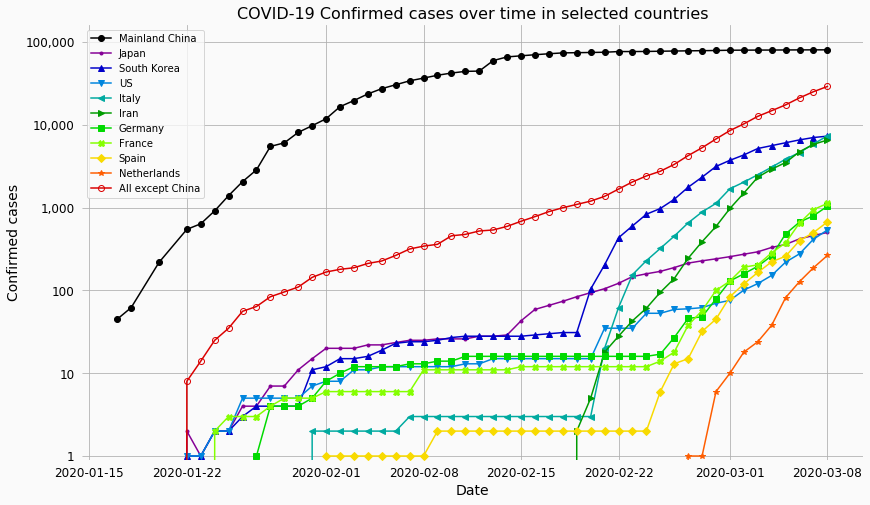

In [44]:
countries_to_plot = ["Mainland China", "Japan", "South Korea", "US", "Italy", "Iran", "Germany",
                     "France", "Spain", "Netherlands", "All except China"]
plot("calendar_date", "confirmed", countries_to_plot)

### Plot cases over days since start of local outbreak in selected countries

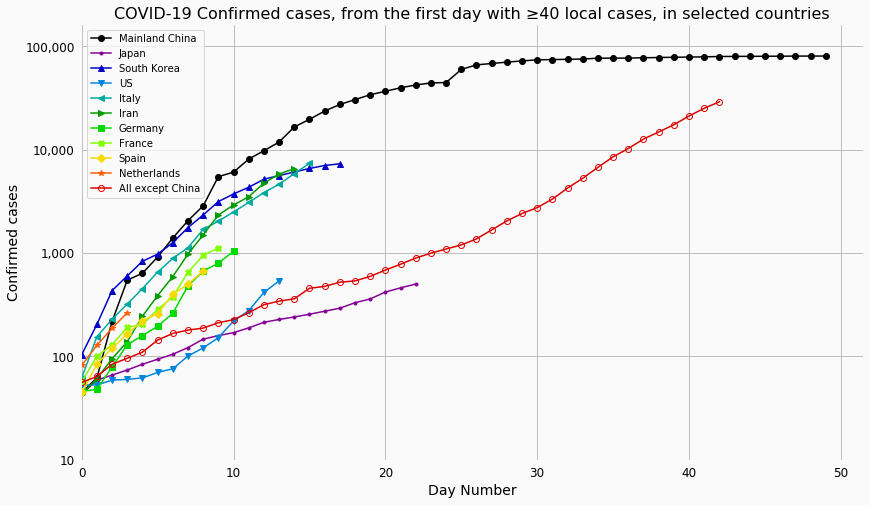

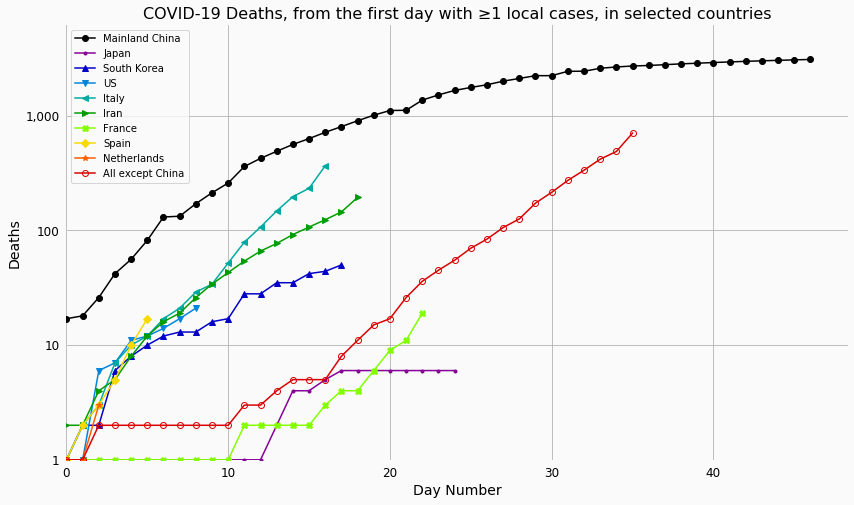

In [45]:
plot("day_number", "confirmed", countries_to_plot, min_cases=40)
plot("day_number", "deaths", countries_to_plot, min_cases=1)

### Smoothed growth factor

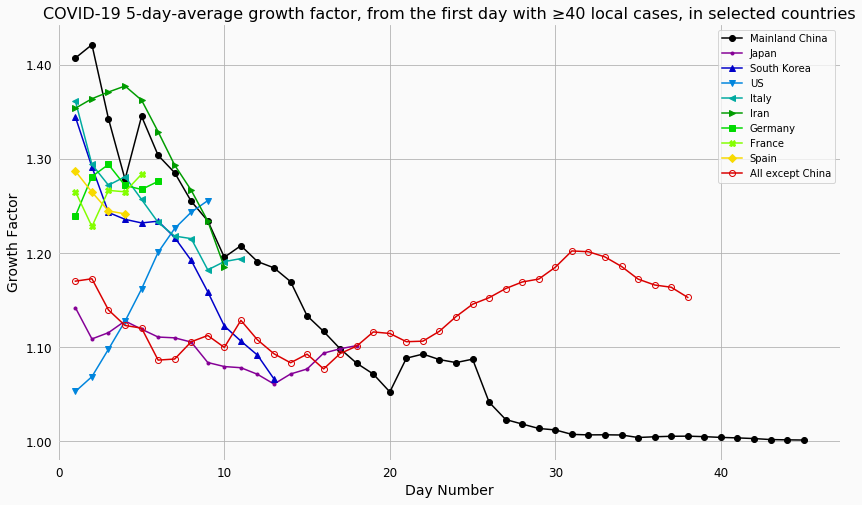

In [46]:
plot("day_number", "growth_factor", countries_to_plot)

### Confirmed cases, deaths and active cases in some other countries

This cell should be relatively easy to experiment in by changing the list of countries, or switching between logarithmic and linear scale.

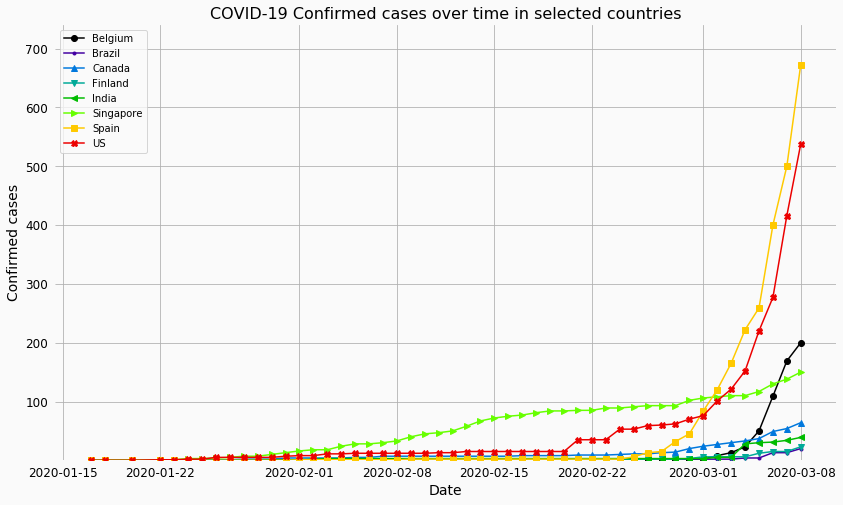

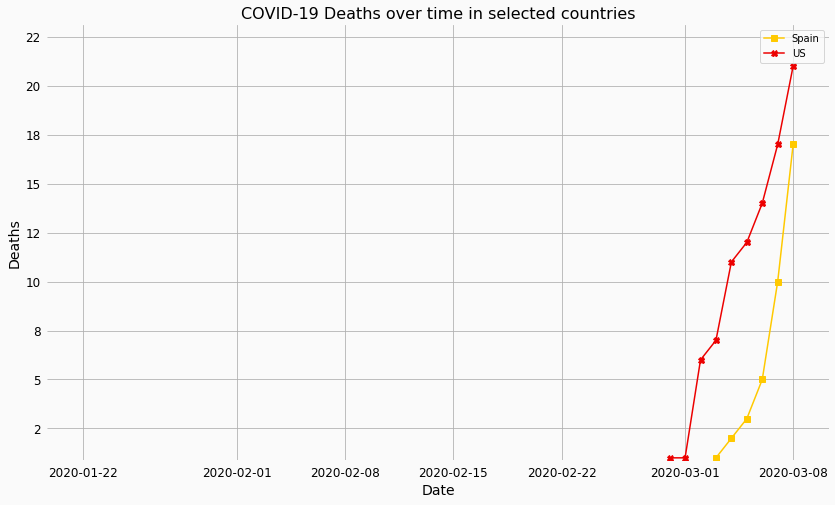

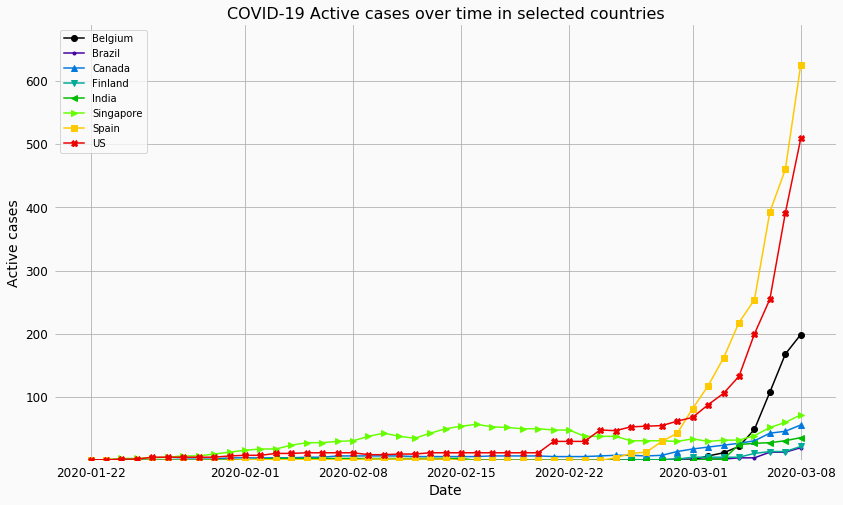

In [47]:
for y_metric in ["confirmed", "deaths", "active"]:
    plot("calendar_date", y_metric, 
         ["Belgium", "Brazil", "Canada", "Finland", "India", "Singapore", "Spain", "US"],
         use_log_scale=False)

### Fit a logistic curve and extrapolate number of future cases

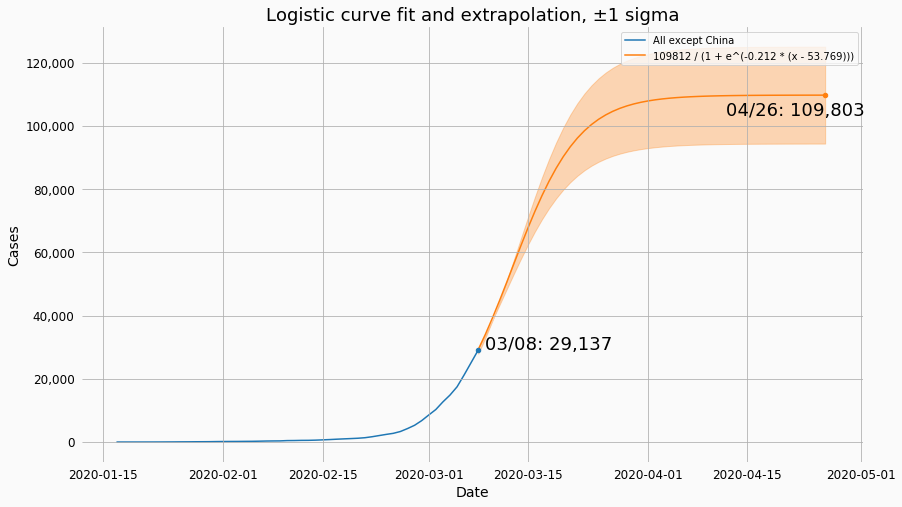

In [48]:
x = np.arange(100)
outside_china = dataframes["confirmed_by_country"].loc["All except China", :]
outside_china = outside_china[np.isfinite(outside_china)]
current_day = outside_china.index[-1]

def func(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

[L, k, x0], pcov =  curve_fit(func, np.arange(len(outside_china)), outside_china, p0=[1e7, 0.5, 70])

plt.plot( outside_china, label="All except China", markersize=3, zorder=1)

# dates up to 100 days after start
model_date_list = [current_day + datetime.timedelta(days = n) for n in range(0, len(x) - len(outside_china))] 
model_date_list = [mdates.date2num(x) for x in model_date_list]

n = len(model_date_list)
sig_L, sig_k, sig_x0 = np.sqrt(np.diag(pcov))
logistic = func(x[n:]-1, L, k, x0)
logistic_plus_sigma = func(x[n:]-1, L+sig_L, k+sig_k, x0+sig_x0)
logistic_minus_sigma = func(x[n:]-1, L-sig_L, k-sig_k, x0-sig_x0)

plt.plot(model_date_list, logistic, label=f"{L:.0f} / (1 + e^(-{k:.3f} * (x - {x0:.3f})))", zorder=1)
plt.fill_between(model_date_list, logistic_minus_sigma, logistic_plus_sigma, alpha=0.3, color="C01")

plt.grid()
plt.legend()
plt.title("Logistic curve fit and extrapolation, ±1 sigma", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Cases", fontsize=14)
plt.scatter(mdates.date2num(current_day), outside_china[-1], s=20, c="C00", zorder=2)
plt.annotate(f"{datetime.datetime.strftime(current_day, '%m/%d')}: {outside_china[-1]:,.0f}", 
             (mdates.date2num(current_day)+1, outside_china[-1]), fontsize=18)

plt.scatter(model_date_list[-1], logistic[-1], s=20, c="C01", zorder=2)
plt.annotate(f"{mdates.num2date(model_date_list[-1]).strftime('%m/%d')}: {logistic[-1]:,.0f}", 
             (model_date_list[-1]-14, logistic[-1]*0.94), fontsize=18)
set_y_axis_format(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().tick_params(which="major", color=light_grey)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()